In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(' # of GPUs available : ', torch.cuda.device_count())

log_interval = 200

 # of GPUs available :  4


### Loading MNIST Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

### Check the dataset size

In [3]:
print(' Training Dataset size : ', trainloader.dataset.train_data.shape)
print(' Training Label size   : ', trainloader.dataset.train_labels.shape)

print(' Testing Dataset size : ', testloader.dataset.test_data.shape)
print(' Testing Label size   : ', testloader.dataset.test_labels.shape)

 Training Dataset size :  torch.Size([60000, 28, 28])
 Training Label size   :  torch.Size([60000])
 Testing Dataset size :  torch.Size([10000, 28, 28])
 Testing Label size   :  torch.Size([10000])


### Visualize dataset

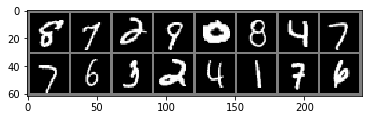

    8     7     2     9     0     8     4     7     7     6     3     2     4     1     7     6


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(16)))

### Build CNN model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.b1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.b2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # Layer 1
        #print(self.num_flat_features(x))
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        #print(self.num_flat_features(x))
        # Layer 2
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        
        # -- Flatten tensors
        #print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))
        
        #print(self.num_flat_features(x))
        # FC Layer 1
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        # FC Layer 2
        x = self.fc2(x)
        return x
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net)

net.to(device)

print(net)

Let's use 4 GPUs!
DataParallel(
  (module): Net(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (b1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1024, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


### Define a loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### Define Trainer

In [7]:
def train(epoch):
    net.train()
    
    running_loss = 0.0
    total = 0
    correct = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # For Multi-gpu processing
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train(True) # Set to Train mode
        outputs = net(inputs)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate Training Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()    

        # print statistics
        running_loss += loss.item()
        if i % log_interval == 0:    # print every 200 mini-batches
            print('Train Epoch : %2d [%6d, %6d] loss: %.3f TrnAcc: %.3f' %
                  (epoch, total, len(trainloader.dataset), running_loss / 2000, correct / total))
            running_loss = 0.0

### Define Validator

In [8]:
def test():
    net.eval()
    # Calculate Validation Accuracy
    total_eval = 0
    correct_eval = 0.0
    with torch.no_grad():
        for images_eval, labels_eval in testloader:
            images_eval, labels_eval = images_eval.to(device), labels_eval.to(device)
            outputs_eval = net(images_eval)
            _, predicted_eval = torch.max(outputs_eval.data, 1)
            total_eval += labels_eval.size(0)
            correct_eval += (predicted_eval == labels_eval).sum().item() 
    val_acc = correct_eval / total_eval
    print('Test | Size : %6d  | ValAcc: %.3f\n' %
          (len(testloader.dataset), val_acc))
    return val_acc

### Train the network

In [9]:
test() # Show initial performance

best_val_acc = 0.0
best_epoch = 0

for epoch in range(3):  # loop over the dataset multiple times
    train(epoch)
    val_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        # Save model
        torch.save(net.module.state_dict(), './results/model.pth')
        torch.save(optimizer.state_dict(), './results/optimizer.pth')
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print('Finished Training')

Test | Size :  10000  | ValAcc: 0.103

Train Epoch :  0 [    16,  60000] loss: 0.001 TrnAcc: 0.062
Train Epoch :  0 [  3216,  60000] loss: 0.123 TrnAcc: 0.691
Train Epoch :  0 [  6416,  60000] loss: 0.039 TrnAcc: 0.797
Train Epoch :  0 [  9616,  60000] loss: 0.027 TrnAcc: 0.839
Train Epoch :  0 [ 12816,  60000] loss: 0.021 TrnAcc: 0.865
Train Epoch :  0 [ 16016,  60000] loss: 0.018 TrnAcc: 0.881
Train Epoch :  0 [ 19216,  60000] loss: 0.015 TrnAcc: 0.894
Train Epoch :  0 [ 22416,  60000] loss: 0.014 TrnAcc: 0.904
Train Epoch :  0 [ 25616,  60000] loss: 0.013 TrnAcc: 0.910
Train Epoch :  0 [ 28816,  60000] loss: 0.012 TrnAcc: 0.916
Train Epoch :  0 [ 32016,  60000] loss: 0.011 TrnAcc: 0.921
Train Epoch :  0 [ 35216,  60000] loss: 0.011 TrnAcc: 0.926
Train Epoch :  0 [ 38416,  60000] loss: 0.010 TrnAcc: 0.929
Train Epoch :  0 [ 41616,  60000] loss: 0.010 TrnAcc: 0.933
Train Epoch :  0 [ 44816,  60000] loss: 0.010 TrnAcc: 0.935
Train Epoch :  0 [ 48016,  60000] loss: 0.009 TrnAcc: 0.938
T

In [10]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
module.conv1.weight 	 torch.Size([32, 1, 5, 5])
module.conv1.bias 	 torch.Size([32])
module.b1.weight 	 torch.Size([32])
module.b1.bias 	 torch.Size([32])
module.b1.running_mean 	 torch.Size([32])
module.b1.running_var 	 torch.Size([32])
module.b1.num_batches_tracked 	 torch.Size([])
module.conv2.weight 	 torch.Size([64, 32, 5, 5])
module.conv2.bias 	 torch.Size([64])
module.b2.weight 	 torch.Size([64])
module.b2.bias 	 torch.Size([64])
module.b2.running_mean 	 torch.Size([64])
module.b2.running_var 	 torch.Size([64])
module.b2.num_batches_tracked 	 torch.Size([])
module.fc1.weight 	 torch.Size([1024, 1024])
module.fc1.bias 	 torch.Size([1024])
module.fc2.weight 	 torch.Size([10, 1024])
module.fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {140305778409616: {'momentum_buffer': tensor([[[[-4.6583e-02, -3.8149e-04, -2.5584e-02,  3.6072e-03,  2.6320e-02],
          [ 1.6405e-02,  9.4977e-03,  9.2752e-03,  3.2109e-02,  7.3920e-02],
          [-3.2018e-02, -

### Refs
https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist

https://nextjournal.com/gkoehler/pytorch-mnist